In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import wavfile
import sys
import os
import re

sys.path.insert(0, '/home/leo_dacasi/Dokumente/summerofcode/ENFify/enfify')
from preprocessing import  bandpass_filter
from enf_estimation import segmented_phase_estimation_DFT0, segmented_phase_estimation_DFT1, segmented_phase_estimation_hilbert
from Rodriguez_Audio_Authenticity import feature, Lambda, lambda_accuracy

In [6]:
def extract_number_cut(file_name):

    """Extract number of Audio file anames to sort them

    Args:
        filenames (string)

    Returns:
        _type_: Paths + Names of cut and uncut audio files
    """

    match = re.match(r'cut_(\d+)_audio\.wav', file_name)
    return int(match.group(1)) if match else float('inf')

def extract_number(file_name):

    """Extract number of Audio file anames to sort them

    Args:
        filenames (string)

    Returns:
        _type_: Paths + Names of cut and uncut audio files
    """

    match = re.match(r'(\d+)_audio\.wav', file_name)
    return int(match.group(1)) if match else float('inf')

In [7]:
uncut_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/raw/synthetic/uncut/audio'
cut_dir = '/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/raw/synthetic/cut/audio'

file_list_uncut = os.listdir(uncut_dir)
file_list_uncut.sort(key=extract_number)
file_list_cut = os.listdir(cut_dir)
file_list_cut.sort(key=extract_number_cut)

band_down_sig = []

for wav_file in file_list_uncut:
    file_path = os.path.join(uncut_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.5, 50.5, fs, 1)
    band_down_sig.append(bandpass_sig)

cut_band_down_sig = []
for wav_file in file_list_cut:
    file_path = os.path.join(cut_dir, wav_file)
    fs, signal = wavfile.read(file_path)
    bandpass_sig = bandpass_filter(signal, 49.5, 50.5, fs, 1)
    cut_band_down_sig.append(bandpass_sig)


In [9]:
N_DFT = 20_000
NUM_CYCLES = 10
F_uncut = []
F_cut = []

for sig in tqdm(band_down_sig):
    F = feature(segmented_phase_estimation_DFT0(sig, fs, NUM_CYCLES, N_DFT, 50))
    F_uncut.append(F)

for sig in tqdm(cut_band_down_sig):
    F = feature(segmented_phase_estimation_DFT0(sig, fs, NUM_CYCLES, N_DFT, 50))
    F_cut.append(F)

100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s]


Characterization probaility: 84.8%
Lambda: -1144.3427500989217


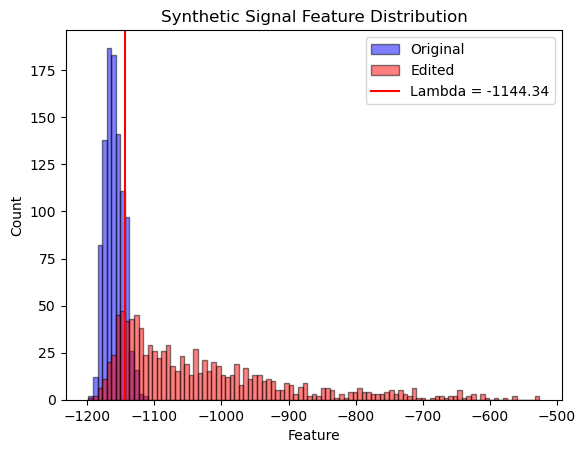

In [21]:
num_samples = len(band_down_sig)
labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples)])
features = np.concatenate([F_uncut, F_cut])

min_val = np.min(features)
max_val = np.max(features)
bins = np.linspace(min_val, max_val,100)

LAMBDA = Lambda(F_uncut, F_cut)
accuracy = lambda_accuracy(F_uncut, F_cut, LAMBDA)
print(f'Characterization probaility: {accuracy*100}%')
print(f'Lambda: {LAMBDA}')

plt.hist(F_uncut, bins=bins,color='blue', alpha=0.5, edgecolor='black',label="Original")
plt.hist(F_cut, bins=bins, color='red', alpha=0.5, edgecolor='black', label="Edited")
plt.xlabel("Feature")
plt.ylabel("Count")
plt.title("Synthetic Signal Feature Distribution")
plt.axvline(LAMBDA, color="red", label=f"Lambda = {round(LAMBDA, 2)}")
plt.legend(loc="best")
#plt.savefig("Syntehtic_feature_distribution.pdf")
plt.show()